In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
!pwd

import os
os.chdir("../../../")

!pwd

/home/breuer/ventilation_system/preplanning/src/preplanning/postprocessing
/home/breuer/ventilation_system/preplanning


In [7]:
import matplotlib.pyplot as plt
plt.style.use("FST.mplstyle")
import numpy as np
import matplotlib.pyplot as plt
from pyomo2h5 import PyomoHDF5Saver, load_yaml

with PyomoHDF5Saver("new_solutions/real_GPZ/preplanning/distributed/af437068-34a5-49ce-b6f3-207522c5202b",mode="r") as saver:
    instance = saver.load_instance()

plt.style.use("FST_bw.mplstyle")

In [8]:
for e in instance.E_vfc:
    if instance.ind_purchase[e].value >1e-3:
        print(e)

print("fs")

for f in instance.fan_set:
    if instance.fan_ind_purchase[f].value > 1e-3:
        print(f"     {f}")

('1-1~1', '1-1~2')
('1-2-1~1', '1-2-1~2')
('1-2-2-1~1', '1-2-2-1~2')
('1-2-2-2~1', '1-2-2-2~2')
('2-2-1~1', '2-2-1~2')
('2-2-2~1', '2-2-2~2')
fs
     ('0~1', '0~2', 'Fan1', 0.3, 1)
     ('0~1', '0~2', 'Fan1', 0.5, 1)
     ('0~1', '0~2', 'Fan2', 0.2, 1)
     ('1~1', '1~2', 'Fan2', 0.4, 1)
     ('1-1~2', '1-1~3', 'Fan2', 0.4, 1)
     ('1-1~2', '1-1~3', 'Fan2', 0.4, 2)
     ('1-2~1', '1-2~2', 'Fan2', 0.4, 1)
     ('1-2~1', '1-2~2', 'Fan2', 0.4, 2)
     ('1-2-1~2', '1-2-1~3', 'Fan2', 0.4, 1)
     ('1-2-1~2', '1-2-1~3', 'Fan2', 0.4, 2)
     ('1-2-2~1', '1-2-2~2', 'Fan2', 0.4, 1)
     ('1-2-2~1', '1-2-2~2', 'Fan2', 0.4, 2)
     ('1-2-2-1~2', '1-2-2-1~3', 'Fan2', 0.4, 1)
     ('1-2-2-1~2', '1-2-2-1~3', 'Fan2', 0.4, 2)
     ('1-2-2-2~2', '1-2-2-2~3', 'Fan2', 0.4, 1)
     ('1-2-2-2~2', '1-2-2-2~3', 'Fan2', 0.4, 2)
     ('2-1~2', '2-1~3', 'Fan2', 0.4, 1)
     ('2-1~2', '2-1~3', 'Fan2', 0.4, 2)
     ('2-2~1', '2-2~2', 'Fan2', 0.4, 1)
     ('2-2~1', '2-2~2', 'Fan2', 0.4, 2)
     ('2-2-1~2', '2-2-1

In [ ]:
reformulation = {("0~1","0~2"): "C1",
                 ("1~1","1~2"): "D2",
                 ("1-2~1","1-2~2"): "D3",
                 ("1-2-2~1","1-2-2~2"): "D4",
                 ("2-2~1","2-2~2"): "D1",
                 ("1-1~2","1-1~3"): "R1",
                 ("1-2-1~2","1-2-1~3"): "R2",
                 ("1-2-2-1~2","1-2-2-1~3"): "R3",
                 ("1-2-2-2~2","1-2-2-2~3"): "R4",
                 ("2-1~2","2-1~3"): "R5",
                 ("2-2-1~2","2-2-1~3"): "R6",
                 ("2-2-2~2","2-2-2~3"): "R7",
                 }

import pandas as pd
from collections import Counter


active_fans = {s:[] for s in instance.Scenarios}
for s in instance.Scenarios:
    n_Fans = 0
    for f in instance.fan_set:
        if instance.scenario[s].fan_ind_active[f].value > 1e-3:
            # print(f"     {reformulation[f[:2]]}")
            reformulation[f[:2]]
            n_Fans += 1
            active_fans[s].append(reformulation[f[:2]])
    # print(n_Fans)

# Count occurrences in each scenario
rows = []
for scenario, fans in active_fans.items():
    count = Counter(fans)
    row = {"Scenario": scenario}
    row.update(count)
    rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows).fillna(0).astype(int)

# Reorder columns: Scenario first, then sorted names (C1, D1, D2, ...)
columns = ["Scenario"] + sorted(set(sum(active_fans.values(), [])))
df = df[columns]
df = df.set_index("Scenario")

1
2
3
4
5
6


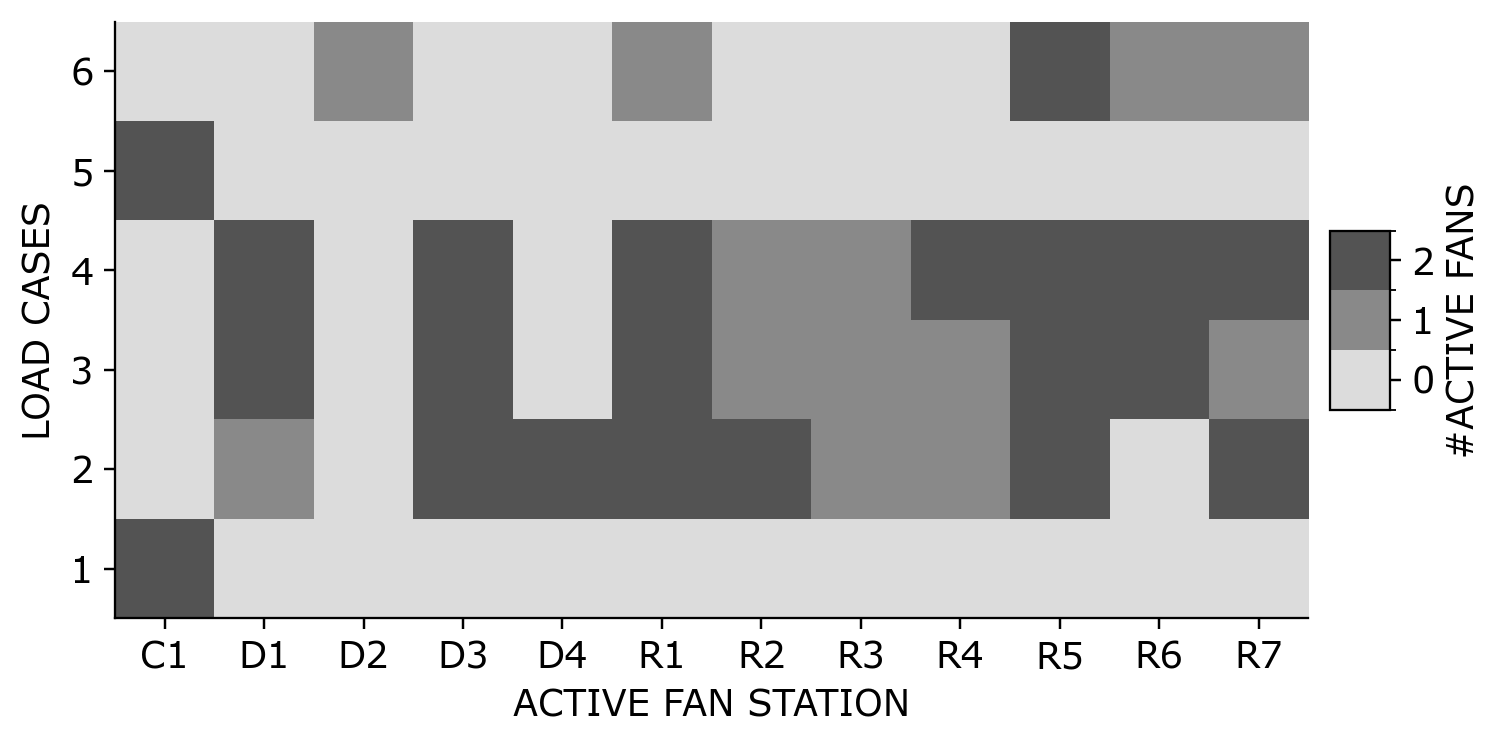

In [55]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the fixed colors for NaN, 1, 2
colors = [[220/255]*3, [137/255]*3, [83/255]*3]
cmap = ListedColormap(colors)

# Define boundaries so each value gets its exact color
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(df, origin='lower', aspect='auto', cmap=cmap, norm=norm)

ax.set_xlabel("ACTIVE FAN STATION")
ax.set_ylabel("LOAD CASES")

ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df.index)
ax.set_xticks(range(len(df.columns)))
ax.set_xticklabels(df.columns)

ax.set_aspect('equal', adjustable='box')
# # Add colorbar with ticks at 0, 1, 2
# cbar = fig.colorbar(im, ax=ax, boundaries=bounds, ticks=[0, 1, 2],  shrink=0.4)
# cbar.set_label("#ACTIVE FANS IN FAN STATION")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
pos = cax.get_position()
cax.set_position([pos.x0, pos.y0 + 0.2, pos.width, pos.height * 0.1])  # shift up, shrink height

cbar = fig.colorbar(im, cax=cax, boundaries=bounds, ticks=[0, 1, 2])
cbar.set_label("#ACTIVE FANS")

# Make the colorbar shorter but keep same width
cax.set_aspect(3)

fig.tight_layout()
fig.savefig("plots/full_paper/min_energy_fan_activity.svg")
fig.savefig("plots/full_paper/min_energy_fan_activity.png")
fig.savefig("plots/full_paper/min_energy_fan_activity.pdf")